In [2]:
# see what molecules, cell types and genes are predicted better and what worse
# fix to cosine-similarity and new dataset

In [2]:
import pandas as pd
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path_to_data = "/Users/arturszalata/PycharmProjects/task-dge-perturbation-prediction/resources/"
path_to_results = os.path.join(path_to_data, "runs/run_2024-05-21_02-14-03")

In [29]:
def mrrmse(de_test_X, prediction, threshold=-np.log(0.0001)):
    mean_rowwise_rmse = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_rmse += np.sqrt((diff**2).mean())
    mean_rowwise_rmse /= de_test_X.shape[0]
    return mean_rowwise_rmse

In [30]:
def mmae(de_test_X, prediction, threshold=-np.log(0.0001)):
    mean_rowwise_mae = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_mae += np.abs(diff).mean()
    
    mean_rowwise_mae /= de_test_X.shape[0]
    return mean_rowwise_mae

In [31]:
def cosine_similarity(de_test_X, prediction, threshold=-np.log(0.0001)):
    mean_cosine_similarity = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            y_i = np.clip(de_test_X[i,], -threshold, threshold)
            y_hat_i = np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            y_i = de_test_X[i,]
            y_hat_i = prediction.iloc[i]
    
        dot_product = np.dot(y_i, y_hat_i)
    
        norm_y_i = np.linalg.norm(y_i)
        norm_y_hat_i = np.linalg.norm(y_hat_i)
    
        cosine_similarity = dot_product / (norm_y_i * norm_y_hat_i)
    
        mean_cosine_similarity += cosine_similarity
    
    mean_cosine_similarity /= de_test_X.shape[0]
    return mean_cosine_similarity

In [32]:
de_test = pd.read_parquet(os.path.join(path_to_data, "neurips-2023-data", "de_test.parquet")).set_index("id")

In [33]:
with open(os.path.join(path_to_results, "score_uns.yaml"), 'r') as file:
    data = yaml.safe_load(file)

# Generate paths
rows = []
for entry in data:
    dataset_id = entry['dataset_id']
    if dataset_id == 'neurips-2023-kaggle':
        continue
    method_id = entry['method_id']
    metric_ids = entry.get('metric_ids', [])
    metric_values = entry.get('metric_values', [])
    for index, metric_id in enumerate(metric_ids):
        metric_value = metric_values[index] if index < len(metric_values) else 'Unknown_value'
        path = f"{dataset_id}.{method_id}.{method_id}.output.parquet"
        rows.append({
                'method_id': method_id,
                metric_id: metric_value,
                'path': path
            })

In [34]:
df = pd.DataFrame(rows)

In [35]:
df = df[~df.method_id.isin(["zeros", "ground_truth"])]

In [36]:
os.path.join(path_to_results, "predictions", f"neurips-2023-data.{method_id}.{method_id}.output.parquet")

'/Users/arturszalata/PycharmProjects/task-dge-perturbation-prediction/resources/runs/run_2024-05-21_02-14-03/predictions/neurips-2023-data.jn_ap_op2.jn_ap_op2.output.parquet'

In [112]:
predictions = {}
for method_id in ["jn_ap_op2", "lstm_gru_cnn_ensemble", "nn_retraining_with_pseudolabels", "scape", "pyboost"]: # transformer_ensemble
    predictions[method_id] = pd.read_parquet(os.path.join(path_to_results, "predictions", f"neurips-2023-data.{method_id}.{method_id}.output.parquet")).set_index("id")

In [113]:
rows = []
for method_id in predictions.keys():
    for cell_type in de_test.cell_type.unique():
        rows.append({
            'method_id': method_id,
            'cell_type': cell_type,
            'mrrmse': mrrmse(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'mae': mmae(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type])
        })

In [114]:
pd.DataFrame(rows)

,method_id,cell_type,mrrmse,cosine_sim,mae
0,jn_ap_op2,B cells,0.413436,0.339739,0.202501
1,jn_ap_op2,Myeloid cells,0.710304,0.258206,0.356084
2,lstm_gru_cnn_ensemble,B cells,0.366585,0.353960,0.180850
3,lstm_gru_cnn_ensemble,Myeloid cells,0.655495,0.318716,0.321800
4,nn_retraining_with_pseudolabels,B cells,0.366206,0.393442,0.189474
5,nn_retraining_with_pseudolabels,Myeloid cells,0.638944,0.375160,0.329343
6,scape,B cells,0.366384,0.378278,0.189935
7,scape,Myeloid cells,0.652726,0.315341,0.333910
8,pyboost,B cells,0.348658,0.429247,0.172193
9,pyboost,Myeloid cells,0.632112,0.409301,0.308832


In [115]:
# B cells are better predicted, but the top method outperforms the other two in both

In [116]:
rows = []
for method_id in predictions.keys():
    for sm_name in de_test.sm_name.unique():
        rows.append({
            'method_id': method_id,
            'sm_name': sm_name,
            'mrrmse': mrrmse(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'mae': mmae(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name])
        })

In [117]:
data = pd.DataFrame(rows)

In [118]:
threshold = -np.log10(0.05)

In [119]:
rows = []
for sm_name in de_test.sm_name.unique():
    rows.append({
            'sm_name': sm_name,
            'sig_genes': (np.abs(de_test.loc[de_test.sm_name == sm_name].iloc[:, 6:]) > threshold).sum().sum() 
        })
sig_genes_df = pd.DataFrame(rows)

In [120]:
data["sig_genes"] = data["sm_name"].map(sig_genes_df.set_index("sm_name")["sig_genes"])

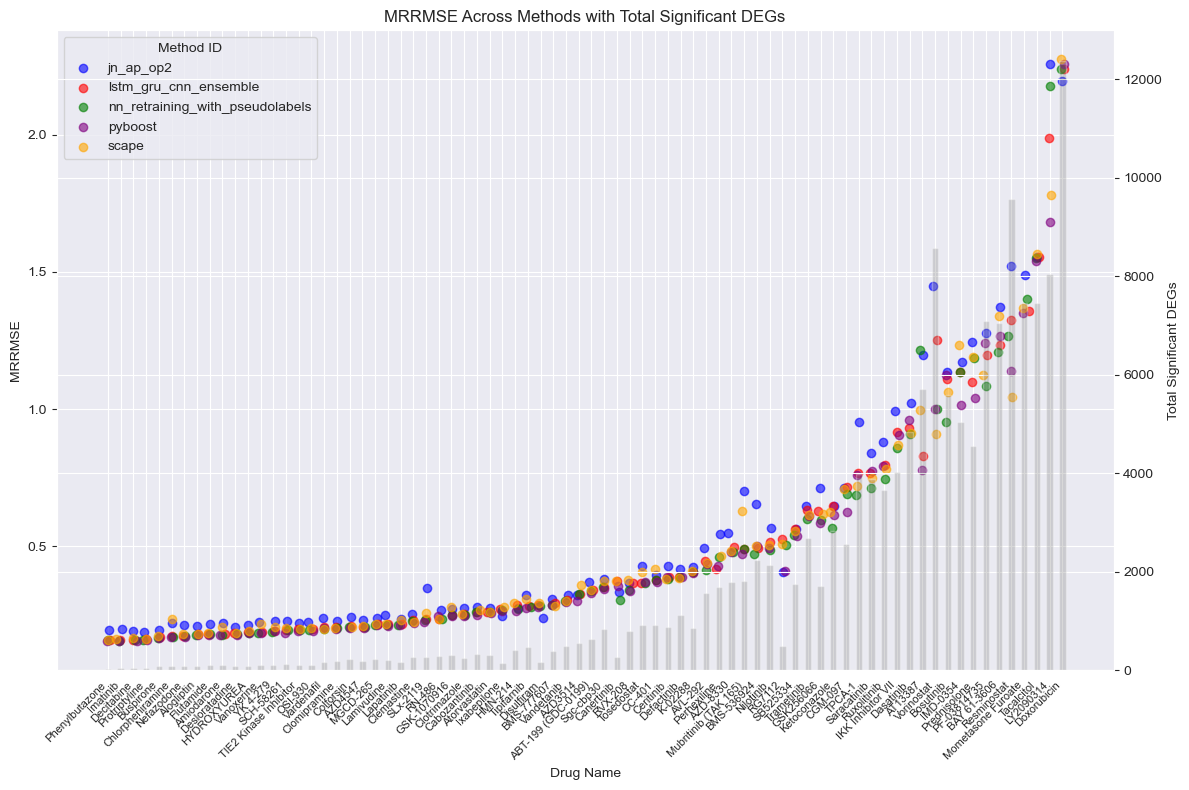

In [46]:
# Add jitter to the x-axis categorical data for better visualization
# Assign a numeric value to each unique 'sm_name' for plotting
median_mrrmse = data.groupby('sm_name')['mrrmse'].median().sort_values()
categories = {name: i for i, name in enumerate(median_mrrmse.index)}
data['sm_jittered'] = data['sm_name'].map(categories) + np.random.normal(0, 0.1, size=len(data))

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax2 = ax.twinx()  # Create another y-axis that shares the same x-axis
total_genes_by_sm = data.groupby('sm_name')['sig_genes'].sum().sort_values()
bars = ax2.bar(categories.values(), total_genes_by_sm.loc[list(categories.keys())], color='gray', alpha=0.3, label='Total Significant DEGs', width=0.5)

colors = {'jn_ap_op2': 'blue', 'nn_retraining_with_pseudolabels': 'green', "lstm_gru_cnn_ensemble": 'red', "scape": "orange", "pyboost": "purple"}
for method, group in data.groupby('method_id'):
    ax.scatter(group['sm_jittered'], group['mrrmse'], color=colors[method], alpha=0.6, label=method)

# Improve the x-axis to show category names
ax.set_xticks(list(categories.values()))
ax.set_xticklabels(list(categories.keys()), rotation=45, ha='right', fontsize=8)

# Set titles and labels
plt.title('MRRMSE Across Methods with Total Significant DEGs')
ax.set_xlabel('Drug Name')
ax.set_ylabel('MRRMSE')
ax2.set_ylabel('Total Significant DEGs')
ax.legend(title='Method ID', loc='upper left')

plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

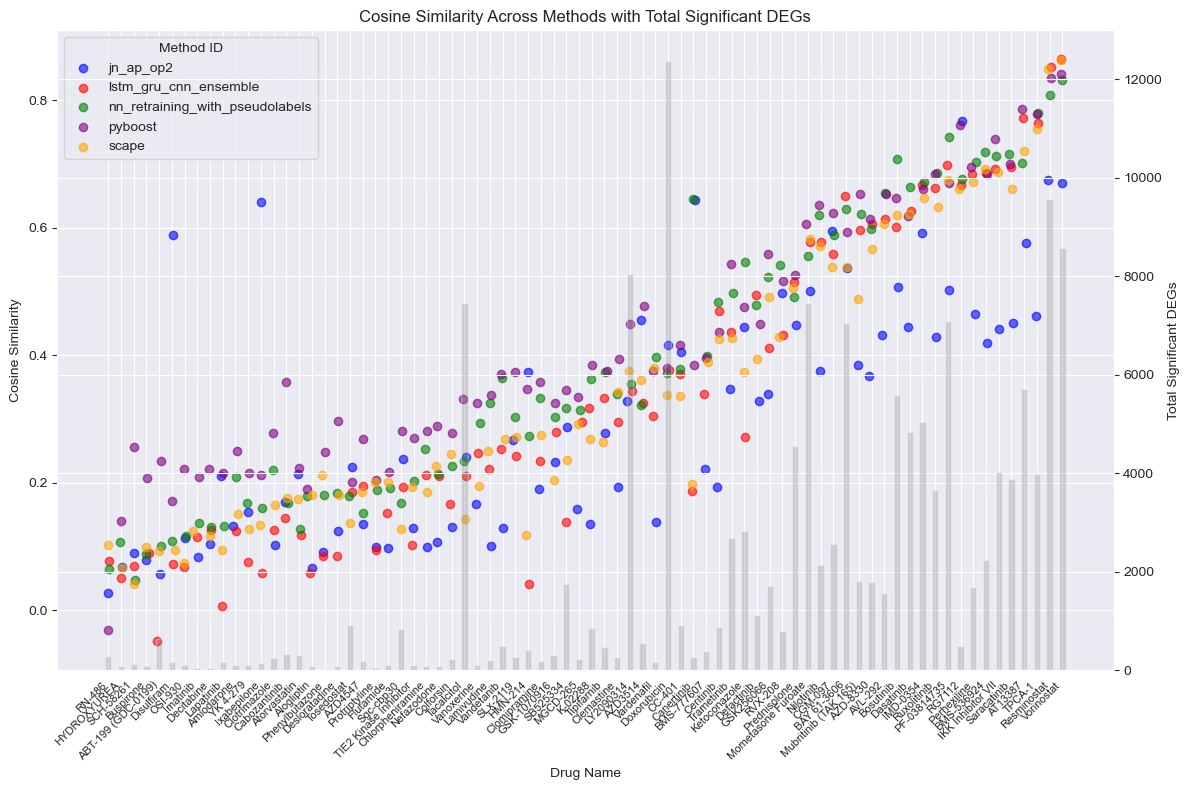

In [47]:
# Add jitter to the x-axis categorical data for better visualization
# Assign a numeric value to each unique 'sm_name' for plotting
median_mrrmse = data.groupby('sm_name')['cosine_sim'].median().sort_values()
categories = {name: i for i, name in enumerate(median_mrrmse.index)}
data['sm_jittered'] = data['sm_name'].map(categories) + np.random.normal(0, 0.1, size=len(data))

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax2 = ax.twinx()  # Create another y-axis that shares the same x-axis
total_genes_by_sm = data.groupby('sm_name')['sig_genes'].sum().sort_values()
bars = ax2.bar(categories.values(), total_genes_by_sm.loc[list(categories.keys())], color='gray', alpha=0.3, label='Total Significant DEGs', width=0.5)

colors = {'jn_ap_op2': 'blue', 'nn_retraining_with_pseudolabels': 'green', "lstm_gru_cnn_ensemble": 'red', "scape": "orange", "pyboost": "purple"}
for method, group in data.groupby('method_id'):
    ax.scatter(group['sm_jittered'], group['cosine_sim'], color=colors[method], alpha=0.6, label=method)

# Improve the x-axis to show category names
ax.set_xticks(list(categories.values()))
ax.set_xticklabels(list(categories.keys()), rotation=45, ha='right', fontsize=8)

# Set titles and labels
plt.title('Cosine Similarity Across Methods with Total Significant DEGs')
ax.set_xlabel('Drug Name')
ax.set_ylabel('Cosine Similarity')
ax2.set_ylabel('Total Significant DEGs')
ax.legend(title='Method ID', loc='upper left')

plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

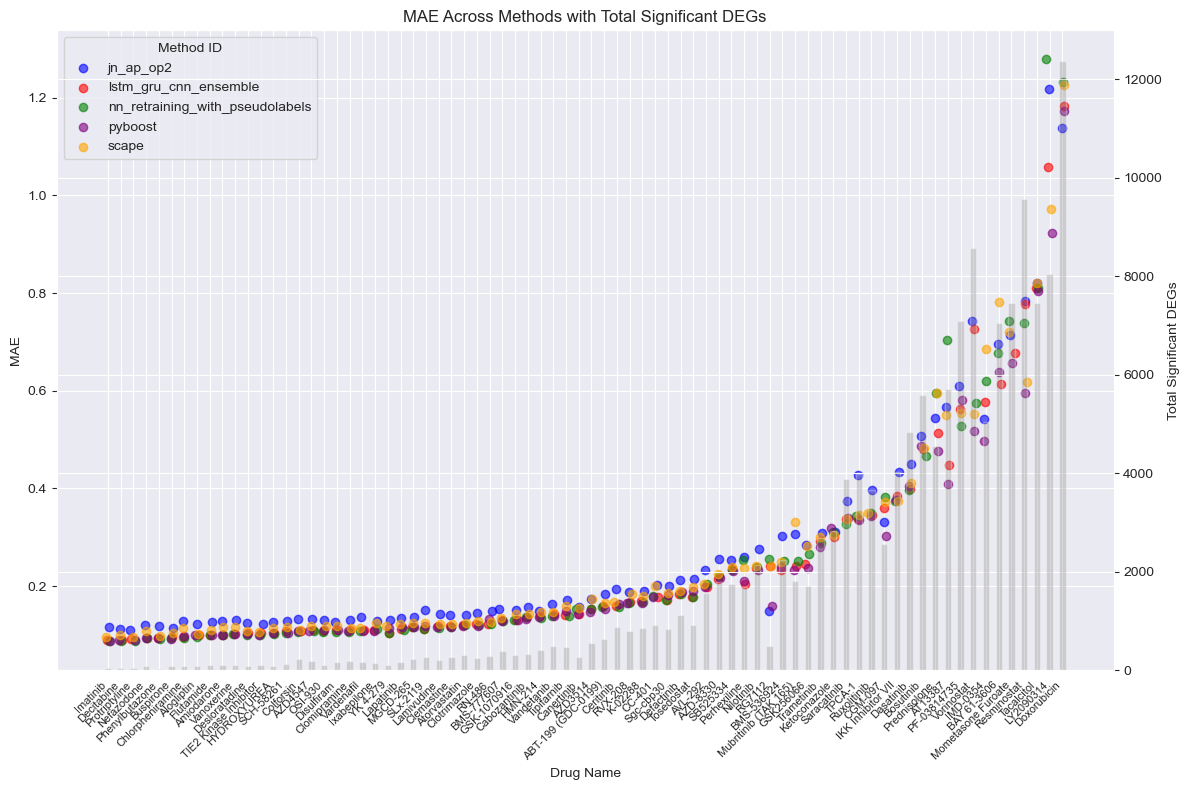

In [48]:
# Add jitter to the x-axis categorical data for better visualization
# Assign a numeric value to each unique 'sm_name' for plotting
median_mrrmse = data.groupby('sm_name')['mae'].median().sort_values()
categories = {name: i for i, name in enumerate(median_mrrmse.index)}
data['sm_jittered'] = data['sm_name'].map(categories) + np.random.normal(0, 0.1, size=len(data))

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax2 = ax.twinx()  # Create another y-axis that shares the same x-axis
total_genes_by_sm = data.groupby('sm_name')['sig_genes'].sum().sort_values()
bars = ax2.bar(categories.values(), total_genes_by_sm.loc[list(categories.keys())], color='gray', alpha=0.3, label='Total Significant DEGs', width=0.5)

colors = {'jn_ap_op2': 'blue', 'nn_retraining_with_pseudolabels': 'green', "lstm_gru_cnn_ensemble": 'red', "scape": "orange", "pyboost": "purple"}
for method, group in data.groupby('method_id'):
    ax.scatter(group['sm_jittered'], group['mae'], color=colors[method], alpha=0.6, label=method)

# Improve the x-axis to show category names
ax.set_xticks(list(categories.values()))
ax.set_xticklabels(list(categories.keys()), rotation=45, ha='right', fontsize=8)

# Set titles and labels
plt.title('MAE Across Methods with Total Significant DEGs')
ax.set_xlabel('Drug Name')
ax.set_ylabel('MAE')
ax2.set_ylabel('Total Significant DEGs')
ax.legend(title='Method ID', loc='upper left')

plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [49]:
# plot DGE vs correctness of prediction

In [59]:
# load moa
moa_annotations = pd.read_csv(os.path.join("../data/complete_data", "moa_annotations.csv"))

In [60]:
data_top = data[data.method_id == "pyboost"].copy()

In [61]:
data_top["moa"] = data_top.sm_name.map(moa_annotations.set_index("sm_name")["moa"])

In [62]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.4)].sm_name.unique()

array(['K-02288', 'RG7112'], dtype=object)

In [63]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.4)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
311,pyboost,K-02288,0.401919,0.384484,0.165884,173,41.963619,BMP inhibitor
347,pyboost,RG7112,0.411110,0.760367,0.159012,100,52.200386,MDM2 inhibitor


In [64]:
# the two above have high MRRMSE and low number of significant genes.

In [73]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
313,pyboost,Vorinostat,1.001827,0.840418,0.517569,1716,68.096096,HDAC inhibitor
319,pyboost,BAY 61-3606,1.265841,0.592883,0.638777,1409,70.020465,Syk inhibitor
343,pyboost,Resminostat,1.139892,0.834711,0.594761,1914,72.084664,HDAC inhibitor
368,pyboost,Mometasone Furoate,1.349422,0.606109,0.655946,1493,71.028017,Glucocorticoid receptor agonist
371,pyboost,PF-03814735,1.239430,0.670031,0.581692,1419,67.108737,Aurora kinase inhibitor


In [74]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)].sm_name.unique()

array(['Vorinostat', 'BAY 61-3606', 'Resminostat', 'Mometasone Furoate',
       'PF-03814735'], dtype=object)

In [76]:
# these 5 are exceptionally well predicted compounds

In [77]:
data_top[data_top.cosine_sim > 0.75]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
313,pyboost,Vorinostat,1.001827,0.840418,0.517569,1716,68.096096,HDAC inhibitor
323,pyboost,AT13387,0.776135,0.786552,0.408242,1140,66.023488,HSP inhibitor
343,pyboost,Resminostat,1.139892,0.834711,0.594761,1914,72.084664,HDAC inhibitor
347,pyboost,RG7112,0.411110,0.760367,0.159012,100,52.200386,MDM2 inhibitor
354,pyboost,TPCA-1,0.757772,0.777487,0.334587,798,58.995746,IKK inhibitor


In [78]:
# these compounds have directionality that's predicted well, even if the MRRMSE is not the best, potentially due to the high number of significant genes

In [80]:
data_top[(data_top.cosine_sim < 0.4) & (data_top.sig_genes > 1000)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
370,pyboost,Doxorubicin,2.258223,0.380038,1.173337,2474,75.162018,unknown
374,pyboost,Tacalcitol,1.540015,0.331151,0.803439,1491,73.105164,Vitamin D receptor agonist


In [81]:
# these compounds have a high number of significant genes, but the directionality is not predicted well

In [85]:
threshold = -np.log10(0.0001)

In [129]:
val = np.clip(de_test.iloc[:, 6:], -threshold, threshold).values.reshape(-1)
pred = np.clip(predictions["pyboost"], -threshold, threshold).values.reshape(-1)
errors = val - pred

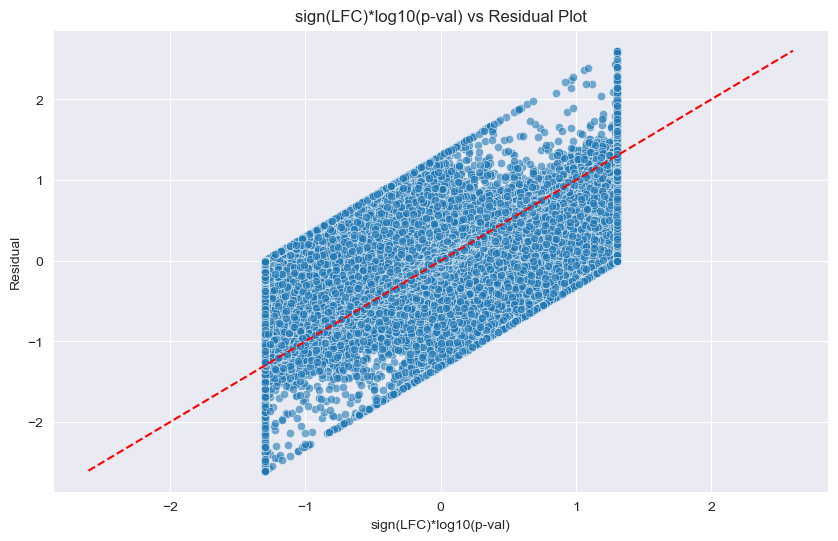

In [130]:
plt.figure(figsize=(10, 6))
plt.scatter(val, errors, alpha=0.6, edgecolors='w', linewidth=0.5)
x_y_line_range = [min(val.min(), errors.min()), max(val.max(), errors.max())]
plt.plot(x_y_line_range, x_y_line_range, 'r--', label='x=y Line')
plt.title('sign(LFC)*log10(p-val) vs Residual Plot')
plt.xlabel('sign(LFC)*log10(p-val)')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [132]:
import seaborn as sns

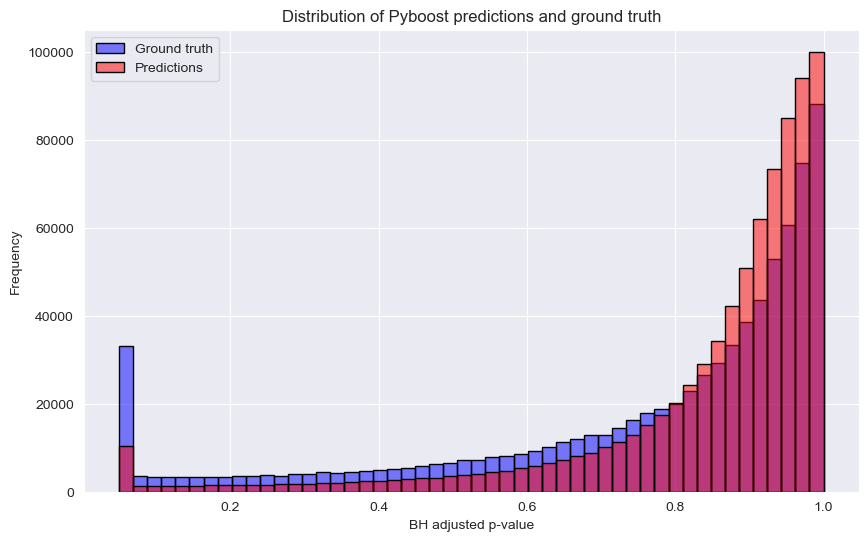

In [158]:
plt.figure(figsize=(10, 6))

sns.histplot(10**-np.abs(val), color='blue', bins=50, edgecolor='black', label='Ground truth', alpha=0.5)

# Plot histogram for val2
sns.histplot(10**-np.abs(pred), color='red', bins=50, edgecolor='black', label='Predictions', alpha=0.5)

# Adding labels and title
plt.title('Distribution of Pyboost predictions and ground truth')
plt.xlabel('BH adjusted p-value')
plt.ylabel('Frequency')

# Adding legend to distinguish the two distributions
plt.legend()

# Show plot with grid
plt.grid(True)
plt.show()

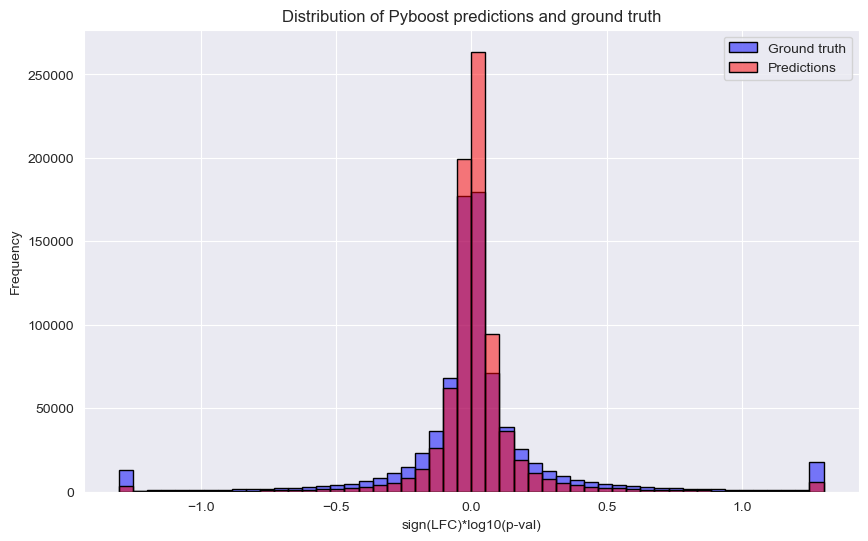

In [159]:
plt.figure(figsize=(10, 6))

sns.histplot(val, color='blue', bins=50, edgecolor='black', label='Ground truth', alpha=0.5)

# Plot histogram for val2
sns.histplot(pred, color='red', bins=50, edgecolor='black', label='Predictions', alpha=0.5)

# Adding labels and title
plt.title('Distribution of Pyboost predictions and ground truth')
plt.xlabel('sign(LFC)*log10(p-val)')
plt.ylabel('Frequency')

# Adding legend to distinguish the two distributions
plt.legend()

# Show plot with grid
plt.grid(True)
plt.show()

In [249]:
values = de_test.iloc[:, 6:].values.reshape(-1)
residuals = errors_per_gene.values.reshape(-1)

# Calculate the ratio of residuals to values
# To avoid division by zero, you can add a small number to the denominator
relative_residuals = np.abs(residuals) / (np.abs(values) + 1e-6)
threshold = np.percentile(relative_residuals, 10)

# Find indices where the relative residuals are below this threshold
small_residual_indices = np.where(relative_residuals < threshold)[0]
num_cols = de_test.shape[1] - 6  # Number of columns you considered in de_test
row_indices = small_residual_indices // num_cols
col_indices = small_residual_indices % num_cols

# Get the gene names corresponding to columns
gene_names = de_test.columns[6:][col_indices]

# Extracting the sample (index) and gene pairs
sample_gene_pairs = list(zip(de_test.index[row_indices], gene_names))

In [107]:
cross_donor_retrieval_ranks_df = pd.read_csv("../data/cross_donor_retrieval_ranks_df.csv")

In [111]:
cross_donor_retrieval_ranks_df = cross_donor_retrieval_ranks_df[cross_donor_retrieval_ranks_df.signature == "sign_log10_pval"]

In [113]:
cross_donor_retrieval_ranks_df["sm_cell_type"] = cross_donor_retrieval_ranks_df.sm_name.astype(str) + "_" + cross_donor_retrieval_ranks_df.cell_type.astype(str)

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_39668/835975274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_donor_retrieval_ranks_df["sm_cell_type"] = cross_donor_retrieval_ranks_df.sm_name.astype(str) + "_" + cross_donor_retrieval_ranks_df.cell_type.astype(str)


In [119]:
sm_celltype_rank = cross_donor_retrieval_ranks_df.groupby("sm_cell_type")["rank"].mean().to_dict()

In [120]:

sig_genes_df["sm_cell_type"] = sig_genes_df.sm_name.astype(str) + "_" + sig_genes_df.cell_type.astype(str)

In [122]:
sig_genes_df["cross_donor_retrieval_ranks"] = sig_genes_df.sm_cell_type.map(sm_celltype_rank)

<Axes: >

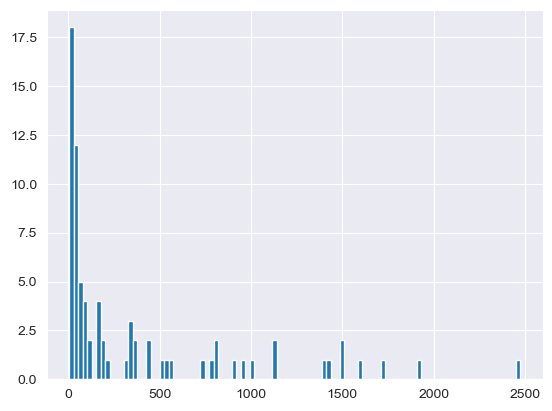

In [190]:
sig_genes_df.sig_genes.hist(bins=100)

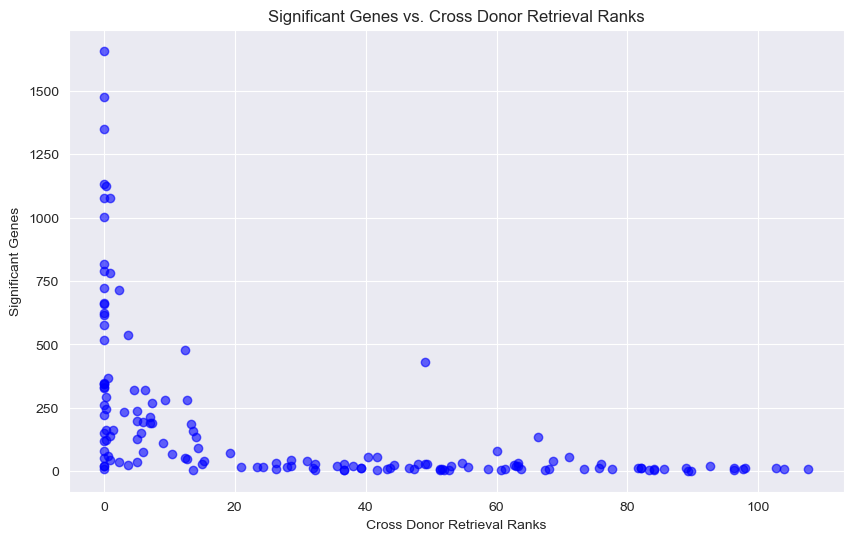

In [125]:
sig_genes_df = sig_genes_df.sort_values(by='cross_donor_retrieval_ranks')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(sig_genes_df['cross_donor_retrieval_ranks'], sig_genes_df['sig_genes'], c='blue', alpha=0.6)

# Adding titles and labels
plt.title('Significant Genes vs. Cross Donor Retrieval Ranks')
plt.xlabel('Cross Donor Retrieval Ranks')
plt.ylabel('Significant Genes')
plt.grid(True)
plt.show()